The goal of this notebook is to prepare reference and visum data and save them as h5ad files
Do not forget to check:
1. check presence of all necessary covariates in adata.obs
2. check number of cell per each type; cell types with less than 20 (50?) cells should be used with caution (it is better to remove them)
3. remove MT genes
4. adata.X stores raw (at least integer) read counts. Try denormalization with CalculateRaw otherwise
5. ensure that both vis and ref use same gene naming (names or ensembl ids).


In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import anndata
from collections import Counter
import glob
import math
import os
import re

# Reference
## load data

In [2]:
lustre_path='/lustre/scratch126/cellgen/cellgeni/tickets/' + os.getcwd().split('/')[4]
lustre_path

'/lustre/scratch117/cellgen/cellgeni/TIC-misc/tic-1796'

Set path to input reference h5ad

In [3]:
ref = sc.read_h5ad('/lustre/scratch117/cellgen/team205/sharedData/kt21/interzone/annotated_interzone_clean.h5ad')

Choose between ref and ref.raw. I give priority to ref, but raw can be used if ref seems too filtered or too normlized.
Total number of genes used by 10x is above 30k, normally about 20k of them are expressed. I would consider dataset as too filtered if number of genes below 20k.

In [4]:
ref.shape

(256004, 4209)

Check raw

In [5]:
ref.raw.shape

(256004, 34734)

So, I'll restore the data from raw

In [6]:
ref = ref.raw.to_adata()

In [7]:
ref.shape

(256004, 34734)

## Check genes
Check whether gene names or ensembl ids are used. If possible set to ensembl id.
This dataset has no ensembl id, so lets use gene names.

In [8]:
ref.var

,gene_ids,n_cells,mt,ribo,hb,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
MIR1302-2HG,MIR1302-2HG,14,False,False,False,14,0.000033,99.996658,14.0,False,0.000018,-0.155509,-3.245577
OR4F5,OR4F5,8,False,False,False,8,0.000019,99.998090,8.0,False,0.000051,0.865610,-0.480361
AL627309.1,AL627309.1,2191,False,False,False,2191,0.005371,99.476973,2250.0,False,0.007677,0.890885,-0.411915
AL627309.3,AL627309.3,38,False,False,False,38,0.000093,99.990929,39.0,False,0.000105,0.330931,-1.928285
AL627309.2,AL627309.2,16,False,False,False,16,0.000038,99.996181,16.0,False,0.000055,0.359453,-1.851045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC004556.3,AC004556.3,2018,False,False,False,2018,0.005462,99.518271,2288.0,False,0.006055,0.776739,-0.721025
AC023491.2,AC023491.2,42,False,False,False,42,0.000100,99.989974,42.0,False,0.000134,0.714501,-0.889567
AC007325.1,AC007325.1,16,False,False,False,16,0.000038,99.996181,16.0,False,0.000038,0.322795,-1.950318
AC007325.4,AC007325.4,12291,False,False,False,12291,0.047091,97.065943,19727.0,False,0.026281,0.780398,-0.711115


Check mitochondrial genes. I'll use "MT-" prefix to detect them. gene names can bo stored in various columns of var, here they are index.

In [13]:
a = [not str(gene).startswith('MT-') for gene in ref.var.index]
Counter(a)

Counter({True: 34721, False: 13})

Filter MT genes out

In [20]:
ref = ref[:,a]
ref.shape

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(256004, 34721)

In [ ]:
#ref.var.set_index('gene_ids', drop=True, inplace=True)

## Check counts
And denormalaze if necessary (using function CalculateRaw)

In [23]:
# from https://github.com/brianpenghe/python-genomics/blob/master/Scanpyplus.py
def CalculateRaw(adata,scaling_factor=10000):
    #update by Polanski in Feb 2022
    #The object must contain a log-transformed matrix
    #This function returns an integer-count object
    #The normalization constant is assumed to be 10000
    #return anndata.AnnData(X=sparse.csr_matrix(np.rint(np.array(np.expm1(adata.X).todense().transpose())*(adata.obs['n_counts'].values).transpose() / scaling_factor).transpose()),\
    #              obs=adata.obs,var=adata.var,obsm=adata.obsm,varm=adata.varm)
    X = np.expm1(adata.X)
    scaling_vector = adata.obs['n_counts'].values / scaling_factor
    #.indptr[i]:.indptr[i+1] provides the .data coordinates where the i'th row of the data resides in CSR
    #which happens to be a cell, which happens to be what we have a unique entry in scaling_vector for
    for i in np.arange(X.shape[0]):
        X.data[X.indptr[i]:X.indptr[i+1]] = X.data[X.indptr[i]:X.indptr[i+1]] * scaling_vector[i]
    return anndata.AnnData(X=np.rint(X),obs=adata.obs,var=adata.var,obsm=adata.obsm,varm=adata.varm)

Check whether numbers in X are integers

In [24]:
ref.X.data

array([0.02978014, 0.02978014, 0.08680505, ..., 2.8685405 , 2.8685405 ,
       2.8685405 ], dtype=float32)

They are not, so lets try to de-normalize

In [25]:
ref = CalculateRaw(ref)
ref.X.data

array([1., 1., 3., ..., 1., 1., 1.], dtype=float32)

Looks interegs now, lets check totals

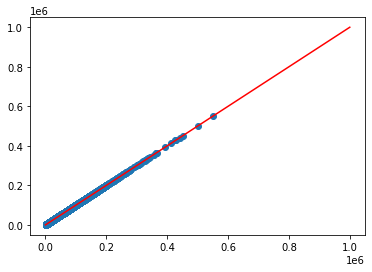

In [27]:
plt.scatter(ref.obs['total_counts'].values - ref.obs['total_counts_mt'].values,ref.X.sum(1).tolist())
plt.plot([0, 1e6], [0, 1e6],color='red')
# n_counts seems to hold sums of log-normalazed data

Identical, so should be raw counts.

## Check obs
Check cell type annotation column ("cell type" in this case as stated  in ticket description). Check covriates (if any) and batches (10x reactions).

In [29]:
ref.obs_keys()

['batch',
 'run_id',
 'scrublet_score',
 'scrublet_leiden',
 'cluster_scrublet_score',
 'doublet_pval',
 'doublet_bh_pval',
 'anatomical_site',
 'pcw',
 'brc_code',
 'percent_mito',
 'percent_ribo',
 'n_counts',
 'n_genes',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_mt',
 'pct_counts_mt',
 'total_counts_ribo',
 'pct_counts_ribo',
 'total_counts_hb',
 'pct_counts_hb',
 'QC',
 'S_score',
 'G2M_score',
 'phase',
 'leiden_1',
 'leiden_2',
 'leiden_3',
 'leiden_4',
 'predicted_labels',
 'over_clustering',
 'majority_voting',
 'cell type',
 'merged']

In [31]:
ref.obs

,batch,run_id,scrublet_score,scrublet_leiden,cluster_scrublet_score,doublet_pval,doublet_bh_pval,anatomical_site,pcw,brc_code,...,phase,leiden_1,leiden_2,leiden_3,leiden_4,predicted_labels,over_clustering,majority_voting,cell type,merged
HCA_BN_F12627470_and_HCA_BN_F12605339-AAACAGCCAAAGGTAC-0,0,HCA_BN_F12627470_and_HCA_BN_F12605339,0.185448,"11,1",0.165175,0.269609,0.752947,knee,8.3,2368.0,...,G2M,8,12,42,50,Interzone cells,182,Interzone cells,Progress zone cells3,Mesenchyme
HCA_BN_F12627470_and_HCA_BN_F12605339-AAACAGCCAACGTGCT-0,0,HCA_BN_F12627470_and_HCA_BN_F12605339,0.178295,"11,12",0.191118,0.132743,0.752947,knee,8.3,2368.0,...,G1,8,12,11,50,MYH3+ myocytes,182,Interzone cells,Progress zone cells3,Mesenchyme
HCA_BN_F12627470_and_HCA_BN_F12605339-AAACAGCCAACTAGAA-0,0,HCA_BN_F12627470_and_HCA_BN_F12605339,0.201133,"15,8",0.185448,0.157606,0.752947,knee,5.8,2370.0,...,G2M,8,12,42,50,Vein endothelial cells,182,Interzone cells,Progress zone cells3,Mesenchyme
HCA_BN_F12627470_and_HCA_BN_F12605339-AAACAGCCACAGCCTG-0,0,HCA_BN_F12627470_and_HCA_BN_F12605339,0.178295,"11,29",0.171548,0.230650,0.752947,knee,5.8,2370.0,...,G2M,8,12,42,50,Interzone cells,182,Interzone cells,Progress zone cells3,Mesenchyme
HCA_BN_F12627470_and_HCA_BN_F12605339-AAACAGCCACCAACCG-0,0,HCA_BN_F12627470_and_HCA_BN_F12605339,0.150685,"11,17",0.185448,0.157606,0.752947,knee,8.3,2368.0,...,G2M,8,12,42,50,Interzone cells,182,Interzone cells,Progress zone cells3,Mesenchyme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HCA_BN_F12922487_and_HCA_BN_F12918725-TTTGTGAAGTTACTTC-21,21,HCA_BN_F12922487_and_HCA_BN_F12918725,0.077461,"7,7",0.025623,0.766337,0.824733,shoulder,7.3,2392.0,...,G2M,3,3,0,51,PAX7+ skeletal muscle progenitors,256,PAX7+ skeletal muscle progenitors,Myoprogenitor5,Muscle
HCA_BN_F12922487_and_HCA_BN_F12918725-TTTGTGTTCGCATTAA-21,21,HCA_BN_F12922487_and_HCA_BN_F12918725,0.031734,"3,0",0.068043,0.546298,0.824733,shoulder,8.6,2394.0,...,G1,2,0,1,52,ADH+ fibroblasts,17,ADH+ fibroblasts,Fibro4,Mesenchyme
HCA_BN_F12922487_and_HCA_BN_F12918725-TTTGTGTTCTGGCATG-21,21,HCA_BN_F12922487_and_HCA_BN_F12918725,0.062988,"11,22",0.091615,0.411791,0.824733,shoulder,7.3,2392.0,...,G2M,0,2,7,37,Interstitial myofibroblasts,225,Resting chondrocytes,Chondro6,Mesenchyme
HCA_BN_F12922487_and_HCA_BN_F12918725-TTTGTTGGTAGGATTT-21,21,HCA_BN_F12922487_and_HCA_BN_F12918725,0.032333,"17,21",0.089184,0.425456,0.824733,shoulder,8.6,2394.0,...,G2M,8,11,10,7,HOXC5+ dermal fibroblast precursors,219,Dermal fibroblasts,Progress zone cells1,Mesenchyme


Seems that batch information is given in "batch" column. It might be "id" or any other column. It could  absent as well.

In [32]:
ref.obs['batch'].value_counts()

12    28277
13    20064
20    17183
18    13878
17    13775
16    13022
15    12229
21    12151
14    11915
19    11446
8     11041
9     10497
0      9913
7      9866
6      9510
11     9371
4      8898
10     7784
5      7651
2      7018
3      6068
1      4447
Name: batch, dtype: int64

In [36]:
cc = ref.obs['cell type'].value_counts()
cc

Osteoprogenitor                      8837
Fibro1                               8664
Fibro progenitor1                    8226
Mesenchyme1                          8004
Endothelial                          7973
Dermal fibroblast                    7705
Myoprogenitor1                       7638
Progress zone cells1                 7453
MYH3+ myocyte                        7381
Chondro1                             7280
Tenocytes                            7233
Tenoprogenitor                       7226
Interzone progenitors                6803
Mesenchyme2                          6126
Dermal fibroblast precursor          5864
DLG2+ myocyte                        5860
Smooth muscle progenitor             5841
Macrophage                           5717
Chondro2                             5642
Mesenchyme3                          5373
Fibro2                               5282
Chondro3                             5276
Chondro4                             5124
Myoprogenitor2                    

Check rare cell types (there are no of them in this dataset)

In [40]:
cc[cc<20]

Series([], Name: cell type, dtype: int64)

In [43]:
ctf = ref.obs['cell type'].isin(cc.index[cc>=20].tolist())
Counter(ctf)

Counter({True: 256004})

Save reference h5ad

In [44]:
sc.write(adata=ref,filename=lustre_path+'/ref.h5ad')

Remove rare cell types if necessary and save filtered dataset.

In [45]:
#ref = ref[ctf,:]
#ref.shape

In [46]:
#sc.write(adata=ref,filename=lustre_path+'/ref.filtered.h5ad')

# Make pseudobulk (optional, can be used to check signatures)

In [137]:
a=[ref.X[ref.obs.celltype==ct,].sum(0)[0] for ct in ref.obs.celltype.cat.categories]
b = np.asarray(a, dtype=float)
b=b[:,0,:].transpose()

In [139]:
b = pd.DataFrame(b) 
b.index = ref.var.index
b.columns = ref.obs.celltype.cat.categories.astype('str')
b

,ADH+Fibro,AER-Basal,ArterialEndo,ArtiChon,B,Basal,CMP/GMP,ChondroProg,DC2,DefErythro,...,SMC,SMProg,STMN2+Fibro,Schwann,SchwannProg,SynapSchwann,Teno,TenoProg,TransMes,VenousEndo
gene_ids,,,,,,,,,,,,,,,,,,,,,
ENSG00000243485,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
ENSG00000238009,9.0,3.0,2.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,...,0.0,1.0,6.0,1.0,1.0,1.0,0.0,3.0,4.0,5.0
ENSG00000239945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000236601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000235146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000277196,1.0,9.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000278384,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0,1.0,4.0
ENSG00000276345,101.0,1.0,17.0,11.0,2.0,14.0,0.0,3.0,9.0,3.0,...,6.0,21.0,14.0,35.0,10.0,22.0,44.0,1.0,10.0,37.0


In [141]:
b.to_csv(lustre_path+"/ref.pseudobulk.csv")

In [148]:
ref.obs.celltype.value_counts().to_csv(lustre_path+"/ref.cellcounts.csv")

# Visium
Visium data can be provided in vareity of ways:
1. Farm paths to SpaceRanger outputs
2. Farm paths to h5ad
3. Irods path
4. ets
Code below assumes that data is on farm

In [83]:
#path2spacerangers = '/lustre/scratch117/cellgen/team205/samsidfetal/'
#path2spacerangers = "/nfs/cellgeni/pasham/tmp/tic-1796"
#sids = ['WSSS_THYst9699523','WSSS_THYst9699524','WSSS_THYst9699525','WSSS_THYst9699526','WSSS_THYst9383359','WSSS_THYst9383360','WSSS_THYst9383361']
#sids
path2spacerangers = lustre_path+"/vis"
sids = [os.path.basename(x) for x in glob(path2spacerangers+"/*")]
sids

['WSSS_THYst9699523',
 'WSSS_THYst9699524',
 'WSSS_THYst9699525',
 'WSSS_THYst9699526',
 'WSSS_THYst9383359',
 'WSSS_THYst9383360',
 'WSSS_THYst9383361']

If SpaceRanger output are in ticket folder

In [1]:
path2spacerangers = lustre_path+"/vis"
sids = [os.path.basename(x) for x in glob(path2spacerangers+"/*")]
sids

NameError: name 'lustre_path' is not defined

Load visium. I'll load all spots including empty ones for later use in QC.

In [84]:
#vs = [sc.read_h5ad(path2spacerangers+'/'+f+'.h5ad') for f in sids] # to load h5ad
vs = [sc.read_visium(path2spacerangers+'/'+f+"/outs/",count_file='raw_feature_bc_matrix.h5') for f in sids] # to load from unmodified soaceranger output (with outs folder)
#vs = [sc.read_visium(path2spacerangers+'/'+f,count_file='raw_feature_bc_matrix.h5') for f in sids] 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

Prepare visiums

In [85]:
for i in range(len(vs)):
    vs[i].obs['barcode'] = vs[i].obs_names
    vs[i].obs_names = sids[i] + '_'+ vs[i].obs_names
    vs[i].obs['library_id']=sids[i]
    vs[i].var_names_make_unique()
    #to change indexing to ensembl ids
    vs[i].var['gene_name'] = vs[i].var_names
    vs[i].var.set_index('gene_ids', drop=True, inplace=True)
    
    # to fix library id in uns
    old_key = list(vs[i].uns['spatial'].keys())[0]
    if sids[i] != old_key:
        vs[i].uns['spatial'][sids[i]] = vs[i].uns['spatial'][old_key]
        del vs[i].uns['spatial'][old_key]


[x.shape[0] for x in vs]

[4992, 4992, 4992, 4992, 4992, 4992, 4992]

In [86]:
vis = vs[0].concatenate(vs[1:],uns_merge='unique')
vis

AnnData object with n_obs × n_vars = 34944 × 33694
    obs: 'in_tissue', 'array_row', 'array_col', 'barcode', 'library_id', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [87]:
vis.obs

,in_tissue,array_row,array_col,barcode,library_id,batch
WSSS_THYst9699523_AAACAACGAATAGTTC-1-0,0,0,16,AAACAACGAATAGTTC-1,WSSS_THYst9699523,0
WSSS_THYst9699523_AAACAAGTATCTCCCA-1-0,0,50,102,AAACAAGTATCTCCCA-1,WSSS_THYst9699523,0
WSSS_THYst9699523_AAACAATCTACTAGCA-1-0,0,3,43,AAACAATCTACTAGCA-1,WSSS_THYst9699523,0
WSSS_THYst9699523_AAACACCAATAACTGC-1-0,0,59,19,AAACACCAATAACTGC-1,WSSS_THYst9699523,0
WSSS_THYst9699523_AAACAGAGCGACTCCT-1-0,1,14,94,AAACAGAGCGACTCCT-1,WSSS_THYst9699523,0
...,...,...,...,...,...,...
WSSS_THYst9383361_TTGTTTCACATCCAGG-1-6,0,58,42,TTGTTTCACATCCAGG-1,WSSS_THYst9383361,6
WSSS_THYst9383361_TTGTTTCATTAGTCTA-1-6,0,60,30,TTGTTTCATTAGTCTA-1,WSSS_THYst9383361,6
WSSS_THYst9383361_TTGTTTCCATACAACT-1-6,1,45,27,TTGTTTCCATACAACT-1,WSSS_THYst9383361,6
WSSS_THYst9383361_TTGTTTGTATTACACG-1-6,0,73,41,TTGTTTGTATTACACG-1,WSSS_THYst9383361,6


Ltes make spot names more meaningfull

In [ ]:
# hope "|" is allowed in index
vis.obs_names = vis.obs['library_id'] + "|" + vis.obs['barcode']
vis.obs = vis.obs.drop(columns='batch',errors='ignore')
vis.obs

In [89]:
vis.var

,gene_ids,feature_types,genome
RP11-34P13.3,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
RP11-34P13.7,ENSG00000238009,Gene Expression,GRCh38
RP11-34P13.8,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38
AC233755.1,ENSG00000275063,Gene Expression,GRCh38
AC240274.1,ENSG00000271254,Gene Expression,GRCh38
AC213203.1,ENSG00000277475,Gene Expression,GRCh38


In [ ]:
# sometimes these fields can be read as string (category) enforce them to int
vis.obs.in_tissue = vis.obs.in_tissue.astype('int')
vis.obs.array_row = vis.obs.array_row.astype('int')
vis.obs.array_col = vis.obs.array_col.astype('int')

In [92]:
vis.write(lustre_path+"/viss.h5ad")